In [3]:
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt

# imports
from skimage import data, color, feature
from skimage.feature import local_binary_pattern

import pandas as pd
from sklearn import svm
from sklearn.decomposition import PCA
from skimage.io import imshow, show
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from scipy import ndimage

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier


In [4]:
#process image and rotate it

def preprocess_image(image):
    resized_image = cv2.resize(image, (128, 64))
    ycrcb_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2YCrCb)

    # Convert the input image to grayscale
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    # Split channels
    y_channel, cr_channel, cb_channel = cv2.split(ycrcb_image)

    # Apply CLAHE to the Y channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    y_channel = clahe.apply(y_channel)

    # Merge channels back together
    enhanced_ycrcb = cv2.merge((y_channel, cr_channel, cb_channel))

    lower_skin = (0, 135, 85)
    upper_skin = (255, 180, 135)

    # Apply the mask
    mask = cv2.inRange(enhanced_ycrcb, lower_skin, upper_skin)

    # Define the kernel size
    kernel_size = 3
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

    # Apply erosion to remove noise
    mask = cv2.erode(mask, kernel, iterations=1)

    # Apply dilation to fill gaps
    mask = cv2.dilate(mask, kernel, iterations=1)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Fill the largest contour (assumed to be the hand)
    if len(contours) > 0:
        max_contour = max(contours, key=cv2.contourArea)
        cv2.drawContours(mask, [max_contour], 0, (255), -1)

    # Apply erosion and dilation
    kernel_size = 7
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

    mask = cv2.erode(mask, kernel, iterations=1)
    mask = cv2.dilate(mask, kernel, iterations=1)

    # Apply the mask to the grayscale image
    masked_gray_image = cv2.bitwise_and(gray_image, gray_image, mask=mask)

    # Apply a bilateral filter to reduce noise while preserving edges
    denoised_image = cv2.GaussianBlur(masked_gray_image, (5, 5), 0)

    return denoised_image


def rotate_image(image, angle):
    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image


In [5]:
# def test_stages(channel, index):
#     # Load a sample images from the dataset

#     sample_image_path = 'dataset/men/' + channel + '/' + channel + '_men (' + str(index) + ').JPG'
#     img = cv2.imread(sample_image_path)

#     # Preprocess the image
#     preprocessed_image = preprocess_image(img)


#     # Display the original, preprocessed images and features
#     fig, axes = plt.subplots(1, 2, figsize=(10, 5))
#     axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     axes[0].set_title("Original Image")
#     axes[1].imshow(preprocessed_image, cmap='gray')
#     axes[1].set_title("Preprocessed Image")
#     plt.show()

# # Test the stages of the preprocessing pipeline by atterating over the channel with 5 indexes
# for index in range(1, 6):
#     test_stages(str(3), str(index))

Image could not be read: dataset2_large/2/2_men (107).JPG
Image could not be read: dataset2_large/2/2_men (108).JPG
Image could not be read: dataset2_large/4/4_men (5).JPG
Image could not be read: dataset2_large/4/4_men (6).JPG
Number of images loaded: 9105


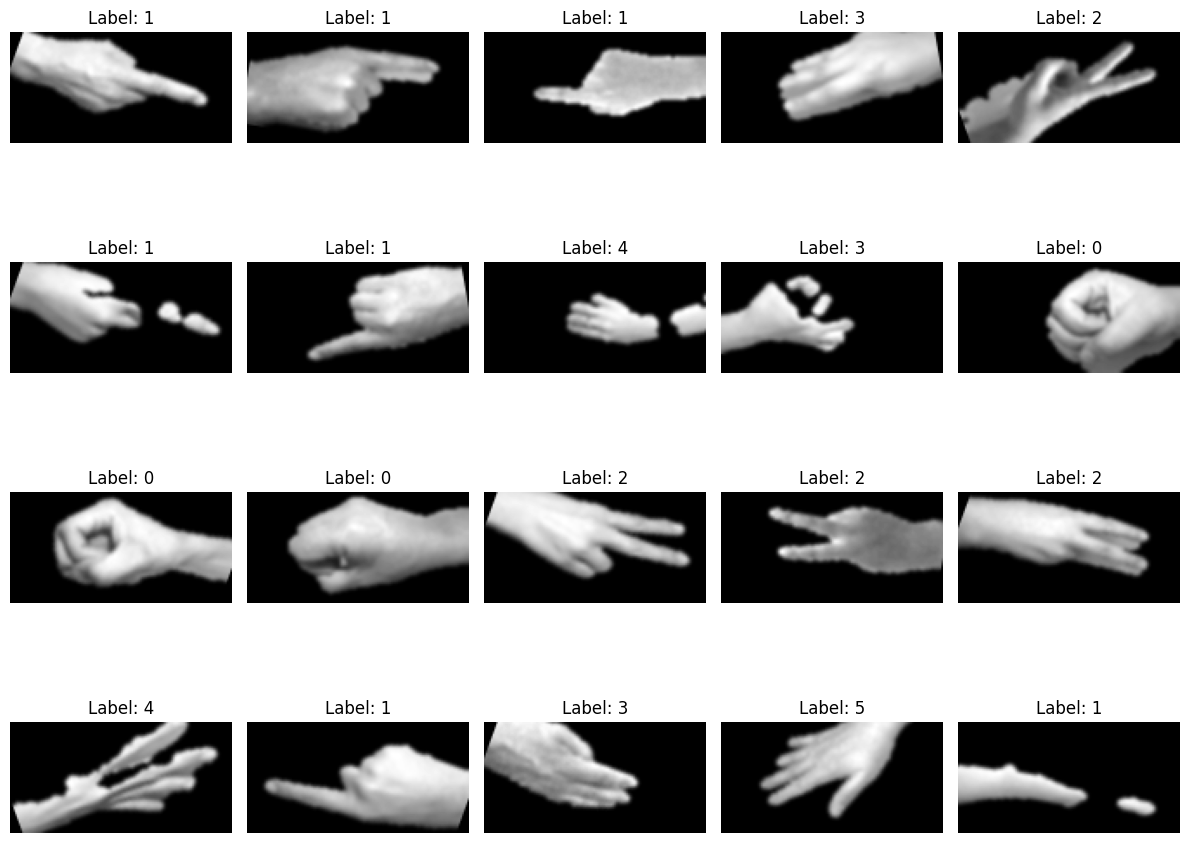

In [6]:
# rotation
data_train = []
labels = []

rotation_angles = [10, -10, 20, -20]  # Define a list of angles for data augmentation

dataset_dir = 'dataset2_large'
#function read and process data
for folder in os.listdir(dataset_dir):
    for img_path in os.listdir(dataset_dir + '/' + folder):
        img = cv2.imread(dataset_dir + '/' + folder + '/' + img_path, -1)
        if img is None:
            print(f'Image could not be read: {dataset_dir}/{folder}/{img_path}')
        else:
            preprocessed_img = preprocess_image(img)

            preprocessed_img = preprocess_image(img)

            # Add the original preprocessed image and label to the data_train and labels lists
            data_train.append(preprocessed_img)
            labels.append(int(folder))

            # Create rotated versions of the preprocessed image and add them to the data_train and labels lists
            for angle in rotation_angles:
                rotated_image = rotate_image(preprocessed_img, angle)
                data_train.append(rotated_image)
                labels.append(int(folder))

print(f'Number of images loaded: {len(data_train)}')

# Get 20 random indices from data_train
random_indices = np.random.choice(len(data_train), size=20, replace=False)

# Plot the 20 random grayscale images
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(12, 10))

#function show some images
for i, ax in enumerate(axes.flatten()):
    # Specify 'gray' colormap for grayscale images
    ax.imshow(data_train[random_indices[i]], cmap='gray')
    ax.set_title(f'Label: {labels[random_indices[i]]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [7]:
# data_train = []
# labels = []

# for folder in os.listdir('dataset2'):
#     for img_path in os.listdir('dataset2/'+folder):
#         img = cv2.imread('dataset2/'+folder+'/'+img_path, -1)
#         preprocessed_img = preprocess_image(img)
#         data_train.append(preprocessed_img)
#         labels.append(int(folder))

# print(f'Number of images loaded: {len(data_train)}')

# # Get 20 random indices from data_train
# random_indices = np.random.choice(len(data_train), size=20, replace=False)

# # Plot the 20 random grayscale images
# fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(12, 10))
# for i, ax in enumerate(axes.flatten()):
#     # Specify 'gray' colormap for grayscale images
#     ax.imshow(data_train[random_indices[i]], cmap='gray')
#     ax.set_title(f'Label: {labels[random_indices[i]]}')
#     ax.axis('off')
# plt.tight_layout()
# plt.show()




In [8]:

def extract_hog_features(image):
    hog_features, _ = feature.hog(image, orientations=9, pixels_per_cell=(8, 8),
                                  cells_per_block=(2, 2), transform_sqrt=True, visualize=True, multichannel=False)
    return hog_features

def extract_lbp_features(image, points=24, radius=3):
    lbp = local_binary_pattern(image, points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, points + 3), range=(0, points + 2))
    hist = hist.astype('float')
    hist /= (hist.sum() + 1e-7)
    return hist

def gabor_features(image, orientations=8, scales=5, sigma=1.0, gamma=0.5):
    gabor_features = []
    for orientation in np.linspace(0, np.pi, orientations, endpoint=False):
        for scale in range(scales):
            freq = 1 / (0.5 * (scale + 1))
            gabor_filter = cv2.getGaborKernel((21, 21), sigma, orientation, freq, gamma, 0, ktype=cv2.CV_32F)
            filtered_image = ndimage.convolve(image, gabor_filter)
            gabor_features.append(filtered_image.mean())
            gabor_features.append(filtered_image.var())
    return np.array(gabor_features)


In [9]:
hog_features = [extract_hog_features(image) for image in data_train]
print(f'HOG feature vector size: {hog_features[0].shape}')

lbp_features = [extract_lbp_features(image) for image in data_train]

# Flatten LBP features
flattened_lbp_features = [lbp_feature.flatten() for lbp_feature in lbp_features]
print(f'Length of flattened LBP features: {len(flattened_lbp_features)}')

# Concatenate HOG, LBP, and Gabor features
combined_features = np.hstack((hog_features, flattened_lbp_features))

print(f'Combined HOG, LBP features shape: {combined_features.shape}')


C:\Users\DreamOnline\AppData\Local\Temp\ipykernel_21572\2321344390.py:2: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  hog_features, _ = feature.hog(image, orientations=9, pixels_per_cell=(8, 8),


HOG feature vector size: (3780,)
Length of flattened LBP features: 9105
Combined HOG, LBP features shape: (9105, 3806)


In [10]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.7)
reduced_features = pca.fit_transform(combined_features)
print(f'Reduced features shape: {reduced_features.shape}')


Reduced features shape: (9105, 149)


In [11]:
# print(f'Number of images loaded: {len(data_train)}')
# print(f'Number of labels loaded: {len(labels)}')
# print(f'Number of reduced features loaded: {len(reduced_features)}')


# X_train, X_test, y_train, y_test = train_test_split(reduced_features, labels, test_size=0.1)

# print(f'Number of Xtraining samples: {len(X_train)}')
# print(f'Number of Xtest samples: {len(X_test)}')
# print(f'Number of ytraining samples: {len(y_train)}')
# print(f'Number of ytest samples: {len(y_test)}')

# # Scale the data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [12]:
# # Train a classifier
# clf = SVC(kernel='linear', C=1)
# clf.fit(X_train, y_train)


In [13]:
classifiers = [
    KNeighborsClassifier(n_neighbors=7),
    # DecisionTreeClassifier(),
    # RandomForestClassifier(),
    # AdaBoostClassifier(),
    # GradientBoostingClassifier(),
    # LogisticRegression(),
    MLPClassifier(),
    SVC(kernel='linear', C=1)
]

# Initialize a dictionary to store the classifier names and their accuracies
classifier_accuracies = {clf.__class__.__name__: [] for clf in classifiers}

# Define the number of iterations
num_iterations = 15

for i in range(num_iterations):
    X_train, X_test, y_train, y_test = train_test_split(reduced_features, labels, test_size=0.1)

    # Scale the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    for clf in classifiers:
        clf_name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        accuracy = clf.score(X_test, y_test)
        classifier_accuracies[clf_name].append(accuracy)

# Print all accuracies for each classifier and the average accuracy
for clf_name, accuracies in classifier_accuracies.items():
    print(f'{clf_name} accuracies: {accuracies}')
    avg_accuracy = np.mean(accuracies)
    print(f'{clf_name} average accuracy: {avg_accuracy}\n')

# Print the classifier with the best average accuracy
best_clf_name = max(classifier_accuracies, key=lambda x: np.mean(classifier_accuracies[x]))
print(f'Best classifier: {best_clf_name} with average accuracy {np.mean(classifier_accuracies[best_clf_name])}')

KNeighborsClassifier accuracies: [0.7730600292825769, 0.7653733528550513, 0.7628111273792094, 0.760614934114202, 0.7683016105417276, 0.780380673499268, 0.7800146412884333, 0.777818448023426, 0.7558565153733529, 0.7701317715959004]
KNeighborsClassifier average accuracy: 0.7694363103953147

MLPClassifier accuracies: [0.7551244509516838, 0.7423133235724744, 0.7573206442166911, 0.7554904831625183, 0.746705710102489, 0.7679355783308931, 0.7609809663250366, 0.7573206442166911, 0.7565885797950219, 0.7730600292825769]
MLPClassifier average accuracy: 0.7572840409956075

SVC accuracies: [0.6705710102489019, 0.6581259150805271, 0.6734992679355783, 0.6562957540263543, 0.6731332357247438, 0.6566617862371888, 0.6753294289897511, 0.6614202049780381, 0.6661786237188873, 0.6767935578330894]
SVC average accuracy: 0.666800878477306

Best classifier: KNeighborsClassifier with average accuracy 0.7694363103953147


In [14]:

# classifiers = [
#     KNeighborsClassifier(n_neighbors=7),
#     # DecisionTreeClassifier(),
#     # RandomForestClassifier(),
#     # AdaBoostClassifier(),
#     # GradientBoostingClassifier(),
#     # LogisticRegression(),
#     MLPClassifier(),
#     SVC(kernel='linear', C=1)
# ]

# # Initialize an empty list to store the classifier names and their accuracies
# classifier_names = []
# accuracies = []

# for clf in classifiers:
#     clf_name = clf.__class__.__name__
#     clf.fit(X_train, y_train)
#     accuracy = clf.score(X_test, y_test)
#     classifier_names.append(clf_name)
#     accuracies.append(accuracy)
#     print(f'{clf_name} accuracy: {accuracy}')

# # Print the classifier with the best accuracy
# best_index = accuracies.index(max(accuracies))
# print(f'\nBest classifier: {classifier_names[best_index]} with accuracy {accuracies[best_index]}')